In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [7]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values #DF에서 실제 값만 따온다
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [11]:
raw_data

array([[-0.11252183, -2.8272038 , -3.7738969 , ...,  0.92528624,
         0.19313742,  1.        ],
       [-1.1008778 , -3.9968398 , -4.2858426 , ...,  1.1196209 ,
        -1.4362499 ,  1.        ],
       [-0.56708802, -2.5934502 , -3.8742297 , ...,  0.90422673,
        -0.42179659,  1.        ],
       ...,
       [-1.1229693 , -2.2529248 , -2.8676281 , ..., -2.0083694 ,
        -1.8083338 ,  0.        ],
       [-0.54770461, -1.8895451 , -2.8397786 , ...,  1.1504486 ,
         0.80493225,  0.        ],
       [-1.3517791 , -2.2090058 , -2.5202247 , ..., -1.577823  ,
        -0.68453092,  0.        ]])

이 예에서는 ECG5000 데이터세트에서 이상을 감지하도록 autoencoder를 훈련합니다. 이 데이터세트에는 각각 140개의 데이터 포인트가 있는 5,000개의 심전도가 포함되어 있습니다. 단순화 된 버전의 데이터세트를 사용하고, 각 예제는 0(비정상 리듬에 해당) 또는 1(정상 리듬에 해당)으로 레이블이 지정됩니다. 여러분은 비정상 리듬을 식별하는 데 관심이 있습니다.

참고: 레이블이 지정된 데이터세트를 사용하므로 지도 학습 문제라고 표현할 수 있습니다. 이 예의 목표는 사용 가능한 레이블이 없는 더 큰 데이터세트에 적용할 수 있는 이상 감지 개념을 설명하는 것입니다(예: 정상 리듬이 수천 개이고 비정상 리듬이 적은 경우).

autoencoder를 사용하여 이상을 어떻게 감지하겠습니까? autoencoder는 재구성 오류를 최소화하도록 훈련되었습니다. **autoencoder는 정상 리듬으로만 훈련한 다음 이 autoencoder를 사용하여 모든 데이터를 재구성합니다.** 여기서 가설은 비정상 리듬의 경우에 재구성 오류가 더 클 것이라는 것입니다. 그런 다음 재구성 오류가 고정 임계값을 초과하는 경우, 리듬을 이상으로 분류합니다.

In [8]:
dataframe.shape

(4998, 141)

In [12]:
# 맨 마지막에 label값이 붙어있다. labels에 값만 추출하자
labels = raw_data[:, -1]
print(labels)
print(labels.shape)

[1. 1. 1. ... 0. 0. 0.]
(4998,)


In [13]:
#다른 데이터 포인트들은 electo cadriogram data ???
data = raw_data[:, 0: -1]
print(data)
print(data.shape)

[[-0.11252183 -2.8272038  -3.7738969  ...  0.12343082  0.92528624
   0.19313742]
 [-1.1008778  -3.9968398  -4.2858426  ...  0.77381971  1.1196209
  -1.4362499 ]
 [-0.56708802 -2.5934502  -3.8742297  ...  0.32109663  0.90422673
  -0.42179659]
 ...
 [-1.1229693  -2.2529248  -2.8676281  ... -2.874136   -2.0083694
  -1.8083338 ]
 [-0.54770461 -1.8895451  -2.8397786  ...  1.261335    1.1504486
   0.80493225]
 [-1.3517791  -2.2090058  -2.5202247  ... -2.2600228  -1.577823
  -0.68453092]]
(4998, 140)


In [14]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size = 0.2, random_state = 21 #random state는 뭐지?
) #train_data == 0.8% test_data 0.2% , train_labels = 0.8% test_labels=0.2%

In [15]:
#데이터 [0,1] 정규화
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

print(min_val)
print(min_val.shape)

tf.Tensor(-6.2808752, shape=(), dtype=float64)
()


In [16]:
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

print(train_data)
print(test_data)

tf.Tensor(
[[0.57030466 0.46561659 0.29058117 ... 0.48504233 0.42335019 0.47598344]
 [0.48320587 0.28246963 0.16471254 ... 0.56756701 0.46772939 0.26923291]
 [0.48144641 0.35151403 0.25972766 ... 0.54794209 0.50775438 0.54298664]
 ...
 [0.41039048 0.24164985 0.13120877 ... 0.52773129 0.56540911 0.50238847]
 [0.53977477 0.41407858 0.28101392 ... 0.51266516 0.43706054 0.44268649]
 [0.29639772 0.15988175 0.18883787 ... 0.53766964 0.54578602 0.40826709]], shape=(3998, 140), dtype=float64)
tf.Tensor(
[[0.48035769 0.28877791 0.19828546 ... 0.45463307 0.52461251 0.3713729 ]
 [0.36878969 0.30728118 0.26587983 ... 0.58551235 0.56629881 0.57264043]
 [0.45354808 0.2557325  0.15979648 ... 0.4801337  0.52847338 0.49527123]
 ...
 [0.48304973 0.36122933 0.27729513 ... 0.32799057 0.3158066  0.26930442]
 [0.4090865  0.27907098 0.22604261 ... 0.39099607 0.45987614 0.42140076]
 [0.42648116 0.17669384 0.14546009 ... 0.47333889 0.55036914 0.37805187]], shape=(1000, 140), dtype=float64)


In [17]:
train_data = tf.cast(train_data, tf.float32) 
test_data = tf.cast(test_data, tf.float32)

a = np.array([0.123456789121212,2,3], dtype=np.float16)  
print("16bit: ", a[0])  
  
a = np.array([0.123456789121212,2,3], dtype=np.float32)  
print("32bit: ", a[0])  
  
b = np.array([0.123456789121212121212,2,3], dtype=np.float64)  
print("64bit: ", b[0])  
  
16bit: 0.1235  
32bit: 0.12345679  
64bit: 0.12345678912121212  

이 데이터셋에서 1로 레이블이 지정된 정상 리듬만 사용하여 autoEncoder 훈련한다.

정상과 비정상 리듬을 분리한다.

In [19]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
print(train_labels)

[ True  True  True ...  True  True  True]


In [20]:
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]
print(normal_train_data)

tf.Tensor(
[[0.57030463 0.46561658 0.29058117 ... 0.48504233 0.4233502  0.47598344]
 [0.48320588 0.28246963 0.16471253 ... 0.567567   0.4677294  0.2692329 ]
 [0.48144642 0.35151404 0.25972766 ... 0.5479421  0.5077544  0.54298663]
 ...
 [0.41039047 0.24164985 0.13120876 ... 0.5277313  0.5654091  0.5023885 ]
 [0.5397748  0.4140786  0.28101394 ... 0.51266515 0.43706053 0.4426865 ]
 [0.29639772 0.15988176 0.18883787 ... 0.53766966 0.545786   0.40826708]], shape=(2359, 140), dtype=float32)


In [22]:
anomalous_train_data = train_data[~train_labels] # not 의 의미였지!
anomalous_test_data = test_data[~test_labels]
print(anomalous_train_data)

tf.Tensor(
[[0.4304001  0.35345322 0.30342638 ... 0.30506894 0.262255   0.2502011 ]
 [0.4494794  0.37906834 0.3202905  ... 0.31546655 0.39611116 0.46317974]
 [0.49198422 0.4355403  0.3698029  ... 0.5260356  0.52524984 0.5278486 ]
 ...
 [0.43457043 0.362154   0.34958026 ... 0.3179064  0.3426891  0.49215436]
 [0.4814947  0.4255184  0.38368973 ... 0.29031053 0.3311408  0.4467481 ]
 [0.4276824  0.3507402  0.31587753 ... 0.3177887  0.33242297 0.419218  ]], shape=(1639, 140), dtype=float32)


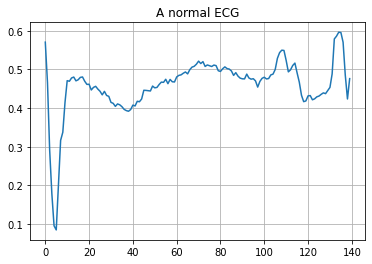

In [30]:
#정상적인 ECG plot
plt.grid()
plt.plot(np.arange(140), normal_train_data[0]) #arange(140) Return evenly spaced values within a given interval.
plt.title("A normal ECG")
plt.show()

np.arange(3)  
array([0, 1, 2])  
np.arange(3.0)  
array([ 0.,  1.,  2.])  
np.arange(3,7)  
array([3, 4, 5, 6])  
np.arange(3,7,2)  
array([3, 5])  


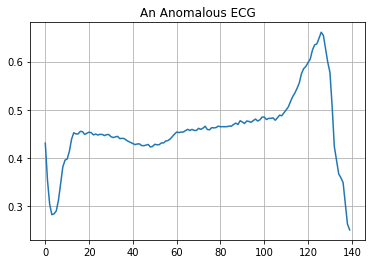

In [31]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

# 1. Model Build

In [53]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(8, activation='relu')])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(140, activation='sigmoid')]) #마지막을 sigmoid가 아니라 relu로 했더니 절딴났다 왜그런걸까?
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [54]:
auto_encoder = AnomalyDetector()

In [55]:
auto_encoder.compile(optimizer='adam', loss = 'mae')

In [56]:
auto_encoder.build(normal_train_data.shape)

In [57]:
EPOCHS = 50
BATCH_SIZE = 512

In [58]:
history = auto_encoder.fit(normal_train_data, normal_train_data,
                           epochs = EPOCHS,
                           batch_size= BATCH_SIZE,
                           validation_data = (test_data, test_data),
                           shuffle=True)

Epoch 1/50
5/5 [==============================] - 1s 37ms/step - loss: 0.0578 - val_loss: 0.0531
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0556 - val_loss: 0.0513
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0528 - val_loss: 0.0493
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0493 - val_loss: 0.0476
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0457 - val_loss: 0.0459
Epoch 6/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0424 - val_loss: 0.0440
Epoch 7/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0390 - val_loss: 0.0426
Epoch 8/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0360 - val_loss: 0.0414
Epoch 9/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0333 - val_loss: 0.0403
Epoch 10/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0308 - val_loss: 0.0391
Epoch 11/50
5/5 [=====================

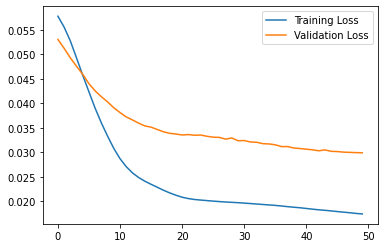

In [59]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()

In [60]:
encoded_imgs = auto_encoder.encoder(normal_test_data).numpy()
decoded_imgs = auto_encoder.decoder(encoded_imgs).numpy()
print(encoded_imgs)
print(type(encoded_imgs))
print(decoded_imgs)

[[0.         0.22595623 3.2184184  ... 0.         0.5234634  0.6616345 ]
 [0.         0.72891825 3.4387677  ... 0.         0.47287992 1.235037  ]
 [0.         0.8366541  3.4885352  ... 0.         0.4486321  1.3636434 ]
 ...
 [0.         0.12451974 3.1129067  ... 0.         0.5505816  0.5295408 ]
 [0.         0.5649192  3.3724186  ... 0.         0.51487076 1.0441755 ]
 [0.         0.6087138  3.397607   ... 0.         0.48821568 1.0925738 ]]
<class 'numpy.ndarray'>
[[0.41832653 0.3007205  0.2517921  ... 0.44601798 0.4555174  0.37517828]
 [0.43077168 0.27720737 0.1828878  ... 0.5243997  0.52793604 0.44453353]
 [0.43336803 0.27201268 0.16985941 ... 0.54101366 0.5436403  0.45965126]
 ...
 [0.42082974 0.310215   0.2683644  ... 0.43369552 0.4443902  0.3648762 ]
 [0.42663732 0.28477034 0.20362514 ... 0.49919105 0.50395215 0.42167988]
 [0.4274931  0.2823418  0.19784576 ... 0.50493306 0.5100703  0.42675522]]


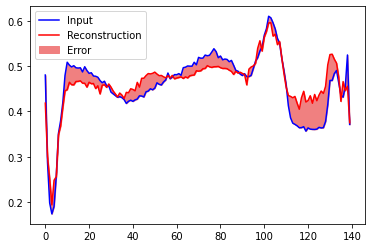

In [61]:
plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

재구성 오류가 정상 훈련 예제에서 하나의 표준 편차보다 큰 경우,   
ECG를 비정상으로 분류합니다.   
먼저, 훈련 세트의 정상 ECG, autoencoder에 의해 인코딩 및 디코딩된 후|의 재구성, 재구성 오류를 플롯해 보겠습니다.

In [63]:
ano_encoded_imgs = auto_encoder.encoder(anomalous_test_data).numpy()
ano_decoded_imgs = auto_encoder.decoder(ano_encoded_imgs).numpy()

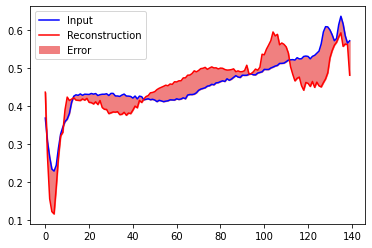

In [64]:
plt.plot(anomalous_test_data[0], 'b')
plt.plot(ano_decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), ano_decoded_imgs[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

# 2. 이상 감지하기

훈련 세트에서 정상 예제에 대한 평균 오차를 계산한 다음,    
재구성 오류가 훈련 세트의 표준 편차보다 큰 경우 향후 예제를 비정상적인 것으로 분류합니다.

In [65]:
reconstructions = auto_encoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

In [66]:
print(reconstructions)
print(train_loss)

[[0.43095678 0.2822631  0.1909831  ... 0.5188649  0.52190155 0.44084516]
 [0.42728958 0.2814571  0.1968593  ... 0.5046881  0.5105387  0.42630908]
 [0.43661958 0.26880568 0.15934032 ... 0.5583663  0.5586043  0.47606122]
 ...
 [0.43076503 0.27683368 0.18245083 ... 0.52441466 0.5282773  0.4444014 ]
 [0.43496028 0.27568355 0.17299287 ... 0.5426018  0.54388046 0.46256557]
 [0.4308685  0.27546045 0.17999437 ... 0.52665526 0.53040195 0.44608203]]
tf.Tensor([0.02715161 0.01029129 0.01279825 ... 0.01217159 0.02140742 0.01597556], shape=(2359,), dtype=float32)


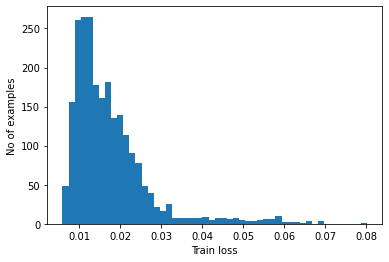

In [67]:
plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [68]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("THRESHOLD : ", threshold)

THRESHOLD :  0.026971273


In [69]:
reconstructions = auto_encoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

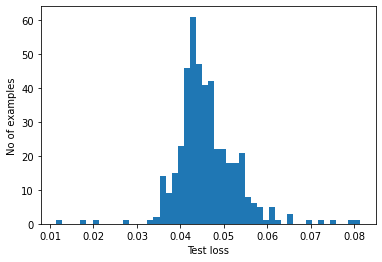

In [70]:
plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [71]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold) #Returns the truth value of (x < y) element-wise.

In [72]:
def print_stats(predictions, labels):
  print("ACC = {}".format(accuracy_score(labels, preds)))
  print("PRECISION = {}".format(precision_score(labels, preds)))
  print("RECALL = {}".format(recall_score(labels, preds)))

In [73]:
preds = predict(auto_encoder, test_data, threshold)
print_stats(preds, test_labels)

ACC = 0.941
PRECISION = 0.9940828402366864
RECALL = 0.9
